In [28]:
# IMPORTANT: this example depends on the cuprates_transport package
# https://github.com/gaelgrissonnanche/cuprates_transport
from cuprates_transport.bandstructure import BandStructure
from cuprates_transport.conductivity import Conductivity

import sys
sys.path.append("..")
import elecboltz

from time import time
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

In [29]:
# matplotlib settings
# reset defaults
mpl.rcdefaults()
# font
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['pdf.fonttype'] = 3
# plotting
mpl.rcParams['figure.figsize'] = (7.48, 4.0)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 20

In [30]:
params_chambers = {
    'band_name': "Nd-LSCO",
    'a': 3.75,
    'b': 3.75,
    'c': 13.2,
    'energy_scale': 160,
    'band_params': {'mu': -0.82439881, 't': 1, 'tp': -0.13642799,
                    'tpp': 0.06816836, 'tz': 0.06512192},
    'resolution': [21, 21, 7],
    'k_max': [np.pi, np.pi, 2*np.pi],
    'N_time': 1000,
    'Bamp': 45,
    'Bphi_array': [0, 15, 30, 45],
    'scattering_models': ['isotropic', 'cos2phi'],
    'scattering_params': {'gamma_0': 12.595, 'gamma_k': 63.823, 'power': 12},
    'march_square': True
}

In [31]:
params_fem = params_chambers.copy()
params_fem['resolution'] = 41
params_fem['domain_size'] = [1.0, 1.0, 2.0]
params_fem['periodic'] = 2
params_fem = elecboltz.easy_params(params_fem)

In [32]:
field_mag = 45
field_phi = np.array([0, 15, 30, 45])
field_theta = np.linspace(-20, 140, 32)

In [33]:
rho_chambers_zz = np.empty((len(field_phi), len(field_theta)))
params_chambers['Bamp'] = field_mag
time_start = time()

band_chambers = BandStructure(**params_chambers)
band_chambers.runBandStructure()
for i, phi in enumerate(field_phi):
    params_chambers['Bphi'] = phi
    for j, theta in enumerate(field_theta):
        params_chambers['Btheta'] = theta
        cond_chambers = Conductivity(band_chambers, **params_chambers)
        cond_chambers.runTransport()
        rho_chambers = np.linalg.inv(cond_chambers.sigma)
        rho_chambers_zz[i, j] = rho_chambers[2, 2]

params_chambers['Btheta'] = 0
cond_chambers = Conductivity(band_chambers, **params_chambers)
cond_chambers.runTransport()
rho_chambers = np.linalg.inv(cond_chambers.sigma)
rho_chambers_zz_0 = rho_chambers[2, 2]

time_end = time()
time_chambers = time_end - time_start

In [34]:
rho_fem_zz = np.empty((len(field_phi), len(field_theta)))
time_start = time()

band_fem = elecboltz.BandStructure(**params_fem)
band_fem.discretize()
cond_fem = elecboltz.Conductivity(band_fem, **params_fem)
cond_fem.Bamp = field_mag
for i, phi in enumerate(field_phi):
    cond_fem.Bphi = phi
    for j, theta in enumerate(field_theta):
        cond_fem.Btheta = theta
        cond_fem.calculate()
        rho_fem = np.linalg.inv(cond_fem.sigma)
        rho_fem_zz[i, j] = rho_fem[2, 2]

cond_fem.Bphi = 0
cond_fem.Btheta = 0
cond_fem.calculate()
rho_fem = np.linalg.inv(cond_fem.sigma)
rho_fem_zz_0 = rho_fem[2, 2]

time_end = time()
time_fem = time_end - time_start

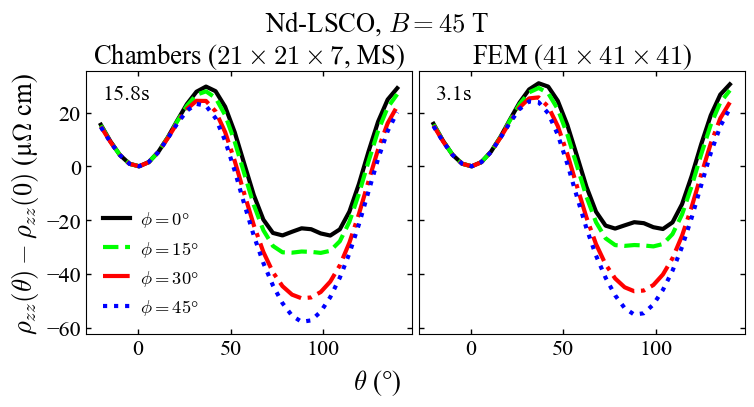

In [35]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
palette = ['black', 'lime', 'red', 'blue']
styles = ['-', '--', '-.', ':']
for i, phi in enumerate(field_phi):
    phi = int(round(phi))
    color = palette[i]
    axs[0].plot(field_theta,
                1e8 * (rho_chambers_zz[i, :] - rho_chambers_zz_0),
                label=rf"$\phi={phi}$°", color=palette[i],
                linestyle=styles[i])
    axs[1].plot(field_theta,
                1e8 * (rho_fem_zz[i, :] - rho_fem_zz_0),
                label=rf"$\phi={phi}$°", color=palette[i],
                linestyle=styles[i])
axs[0].text(0.05, 0.95, f"{time_chambers:.1f}s", fontsize='medium',
            ha='left', va='top', transform=axs[0].transAxes)
axs[1].text(0.05, 0.95, f"{time_fem:.1f}s", fontsize='medium',
            ha='left', va='top', transform=axs[1].transAxes)
fig.suptitle(fr"Nd-LSCO, $B={field_mag}$ T")
chambers_title = (
    fr"Chambers (${params_chambers['resolution'][0]}"
    fr"\times{params_chambers['resolution'][1]}"
    fr"\times{params_chambers['resolution'][2]}$,")
chambers_title += " MS)" if params_chambers['march_square'] else " MC)"
axs[0].set_title(chambers_title)
axs[1].set_title(
    fr"FEM (${band_fem.resolution[0]}"
    fr"\times{band_fem.resolution[1]}"
    fr"\times{band_fem.resolution[2]}$)")
fig.supxlabel(r"$\theta$ (°)", va='bottom')
axs[0].set_ylabel(r"$\rho_{zz}(\theta)-\rho_{zz}(0)$ (µ$\Omega$ cm)",
                  fontsize='large')
axs[0].legend(frameon=False, handlelength=1.5, handletextpad=0.5)
plt.tight_layout(pad=0.3)
plt.savefig("NdLSCO/ADMR_NdLSCO_FEM_vs_Chambers.pdf", bbox_inches='tight')
plt.show()

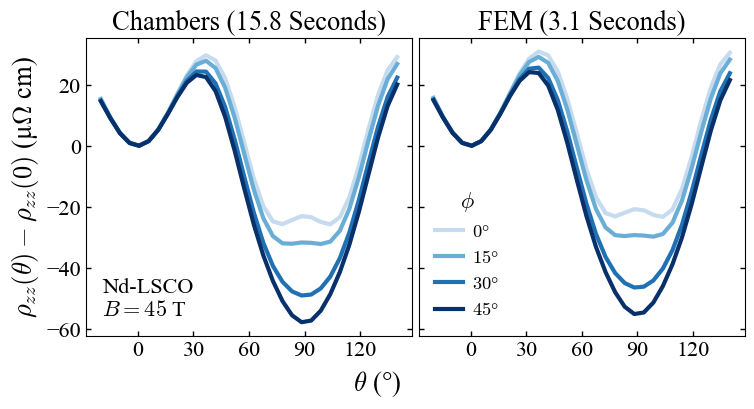

In [37]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
for i, phi in enumerate(field_phi):
    axs[0].plot(field_theta,
                1e8 * (rho_chambers_zz[i, :] - rho_chambers_zz_0),
                label=f"${phi}$°",
                color=mpl.cm.Blues((i+1) / len(field_phi)))
    axs[1].plot(field_theta,
                1e8 * (rho_fem_zz[i, :] - rho_fem_zz_0),
                label=f"${phi}$°",
                color=mpl.cm.Blues((i+1) / len(field_phi)))
axs[0].text(0.05, 0.05, f"Nd-LSCO\n$B={field_mag}$ T",
            ha='left', va='bottom', transform=axs[0].transAxes)
axs[0].set_title(f"Chambers ({time_chambers:.1f} Seconds)")
axs[1].set_title(f"FEM ({time_fem:.1f} Seconds)")
fig.supxlabel(r"$\theta$ (°)", va='bottom')
axs[0].set_ylabel(r"$\rho_{zz}(\theta)-\rho_{zz}(0)$ (µ$\Omega$ cm)",
                  fontsize='large')
axs[1].legend(frameon=False, handlelength=1.5, handletextpad=0.5,
              title=r"$\phi$")
axs[0].set_xticks([0, 30, 60, 90, 120])
axs[1].set_xticks([0, 30, 60, 90, 120])
plt.tight_layout(pad=0.3)
plt.savefig("NdLSCO/ADMR_NdLSCO_FEM_vs_Chambers_report.pdf", bbox_inches='tight')
plt.show()

In [9]:
field_mag = 45
field_phi = np.array([0, 15, 30, 45])
field_theta = np.linspace(-20, 140, 100)

rho_chambers_zz = np.empty((len(field_phi), len(field_theta)))
params_chambers['Bamp'] = field_mag

band_chambers = BandStructure(**params_chambers)
band_chambers.runBandStructure()
for i, phi in enumerate(field_phi):
    params_chambers['Bphi'] = phi
    for j, theta in enumerate(field_theta):
        params_chambers['Btheta'] = theta
        cond_chambers = Conductivity(band_chambers, **params_chambers)
        cond_chambers.runTransport()
        rho_chambers = np.linalg.inv(cond_chambers.sigma)
        rho_chambers_zz[i, j] = rho_chambers[2, 2]

params_chambers['Btheta'] = 0
cond_chambers = Conductivity(band_chambers, **params_chambers)
cond_chambers.runTransport()
rho_chambers = np.linalg.inv(cond_chambers.sigma)
rho_chambers_zz_0 = rho_chambers[2, 2]

rho_fem_zz = np.empty((len(field_phi), len(field_theta)))
time_start = time()

band_fem = elecboltz.BandStructure(**params_fem)
band_fem.discretize()
cond_fem = elecboltz.Conductivity(band_fem, **params_fem)
cond_fem.Bamp = field_mag
for i, phi in enumerate(field_phi):
    cond_fem.Bphi = phi
    for j, theta in enumerate(field_theta):
        cond_fem.Btheta = theta
        cond_fem.calculate()
        rho_fem = np.linalg.inv(cond_fem.sigma)
        rho_fem_zz[i, j] = rho_fem[2, 2]

cond_fem.Bphi = 0
cond_fem.Btheta = 0
cond_fem.calculate()
rho_fem = np.linalg.inv(cond_fem.sigma)
rho_fem_zz_0 = rho_fem[2, 2]

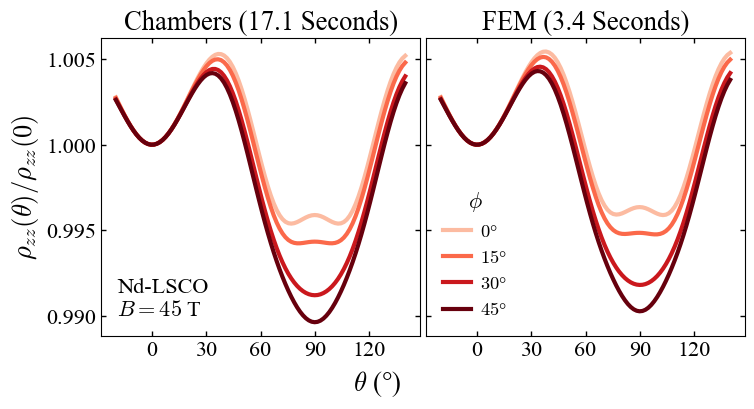

In [10]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
for i, phi in enumerate(field_phi):
    axs[0].plot(field_theta, (rho_chambers_zz[i, :] / rho_chambers_zz_0),
                label=f"${phi}$°",
                color=mpl.cm.Reds((i+1) / len(field_phi)))
    axs[1].plot(field_theta, (rho_fem_zz[i, :] / rho_fem_zz_0),
                label=f"${phi}$°",
                color=mpl.cm.Reds((i+1) / len(field_phi)))
axs[0].text(0.05, 0.05, f"Nd-LSCO\n$B={field_mag}$ T",
            ha='left', va='bottom', transform=axs[0].transAxes)
axs[0].set_title(f"Chambers ({time_chambers:.1f} Seconds)")
axs[1].set_title(f"FEM ({time_fem:.1f} Seconds)")
fig.supxlabel(r"$\theta$ (°)", va='bottom')
axs[0].set_ylabel(r"$\rho_{zz}(\theta)/\rho_{zz}(0)$",
                  fontsize='large')
axs[1].legend(frameon=False, handlelength=1.5, handletextpad=0.5,
              title=r"$\phi$")
axs[0].set_xticks([0, 30, 60, 90, 120])
axs[1].set_xticks([0, 30, 60, 90, 120])
plt.tight_layout(pad=0.3)
plt.savefig("NdLSCO/ADMR_NdLSCO_FEM_vs_Chambers_presentation.pdf", bbox_inches='tight')
plt.show()